In [1]:
%matplotlib inline

import pandas as pd
from skbio.stats.composition import clr, closure
from matplotlib.colors import ListedColormap
from numpy.random import permutation
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import os
from collections import defaultdict

from multiprocessing import Pool, cpu_count
import seaborn as sns
import matplotlib.pyplot as plt

def save_plot(fig, pltname, artists=(), size_inches=(4,4)):
    fig.set_size_inches(size_inches)
    fig.savefig(os.path.join("figures", "genes_comparison_" + pltname + ".png"), dpi=600, bbox_extra_artists=artists, bbox_inches='tight', transparent=False)
    
def custom_legend(fig, colors, labels, legend_location="center left", legend_boundary = (1,.5), marker="o"):
    # Create custom legend for colors"
    patches = [ plt.plot([],[], marker=marker, ms=10, ls="", mec=None, color=colors[i], label="{:s}".format(labels[i]) )[0]  for i in range(len(labels)) ]
    artist = fig.legend(patches, labels, loc=legend_location, bbox_to_anchor=legend_boundary, fontsize=8)
    return artist

def multiplicative_replacement2(mat, delta=None):
    r"""Replace all zeros with small non-zero values
    It uses the multiplicative replacement strategy [1]_ ,
    replacing zeros with a small positive :math:`\delta`
    and ensuring that the compositions still add up to 1.
    Parameters
    ----------
    mat: array_like
       a matrix of proportions where
       rows = compositions and
       columns = components
    delta: float, optional
       a small number to be used to replace zeros
       If delta is not specified, then the default delta is
       :math:`\delta = \frac{1}{N^2}` where :math:`N`
       is the number of components
    Returns
    -------
    numpy.ndarray, np.float64
       A matrix of proportions where all of the values
       are nonzero and each composition (row) adds up to 1
    Raises
    ------
    ValueError
       Raises an error if negative proportions are created due to a large
       `delta`.
    Notes
    -----
    This method will result in negative proportions if a large delta is chosen.
    References
    ----------
    .. [1] J. A. Martin-Fernandez. "Dealing With Zeros and Missing Values in
           Compositional Data Sets Using Nonparametric Imputation"
    Examples
    --------
    >>> import numpy as np
    >>> from skbio.stats.composition import multiplicative_replacement
    >>> X = np.array([[.2,.4,.4, 0],[0,.5,.5,0]])
    >>> multiplicative_replacement(X)
    array([[ 0.1875,  0.375 ,  0.375 ,  0.0625],
           [ 0.0625,  0.4375,  0.4375,  0.0625]])
    """
    mat = np.array(mat)
    z_mat = (mat == 0)

    num_feats = mat.shape[-1]
    tot = np.sum(z_mat, axis=-1, keepdims=True)

    if delta is None:
        delta = np.min((np.min(mat[mat > 0])*.55, (1. / num_feats)**2))

    zcnts = 1 - ((tot * delta)/mat.sum(axis=-1, keepdims=True))
    if np.any(zcnts) < 0:
        raise ValueError('The multiplicative replacment created negative '
                         'proportions. Consider using a smaller `delta`.')
    mat = np.where(z_mat, delta, zcnts * mat)
    return mat.squeeze()

In [2]:
df_direct_shotgun = pd.read_csv("data/keggtable.burst.genes.txt", sep="\t", index_col=0)
df_imputed_shotgun = pd.read_csv("data/burst.species.100k.genes.function/taxa.subsampled.species.kegg.txt", sep="\t", index_col=0)
df_picrust_16s = pd.read_csv("data/16s_gg.genes.txt", sep="\t", index_col=0, skiprows=1)

In [3]:
df_direct_shotgun = df_direct_shotgun[[';K' in _ for _ in df_direct_shotgun.index]]
df_direct_shotgun['KEGGS'] = [_.split(';')[-1] for _ in df_direct_shotgun.index]
df_direct_shotgun = df_direct_shotgun.groupby('KEGGS').sum()

In [4]:
df_picrust_16s = df_picrust_16s.drop("KEGG_Description", axis=1)

In [5]:
df_direct_shotgun.shape

(4473, 180)

In [6]:
df_imputed_shotgun.shape

(6570, 180)

In [7]:
df_picrust_16s.shape

(6909, 180)

In [8]:
df_picrust_16s.columns

Index(['SRS015470', 'SRS011584', 'SRS014271', 'SRS011529', 'SRS024347',
       'SRS016225', 'SRS015921', 'SRS014923', 'SRS018439', 'SRS047219',
       ...
       'SRS018769', 'SRS063417', 'SRS044474', 'SRS021484', 'SRS023914',
       'SRS023987', 'SRS024064', 'SRS016559', 'SRS015425', 'SRS016585'],
      dtype='object', length=180)

In [9]:
df_picrust_16s.index

Index(['K01365', 'K01364', 'K01361', 'K01360', 'K01362', 'K02249', 'K05841',
       'K05844', 'K05845', 'K05846',
       ...
       'K05908', 'K00368', 'K00369', 'K00366', 'K00367', 'K00364', 'K00365',
       'K00362', 'K00363', 'K00360'],
      dtype='object', name='#OTU ID', length=6909)

In [10]:
# Preprocess columns for SRS IDs
df_direct_shotgun.columns = map(lambda x: x.split(".")[0], df_direct_shotgun.columns)
df_imputed_shotgun.columns = map(lambda x: x.split(".")[0], df_imputed_shotgun.columns)

In [11]:
# Verify all SRS IDs exist in both DFs
print(len(set(df_imputed_shotgun.columns).intersection(df_picrust_16s.columns)) == df_picrust_16s.shape[1])

True


In [12]:
def stylize_axes(ax):
    """Customize axes spines, title, labels, ticks, and ticklabels."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top='off', direction='out', width=1)
    ax.yaxis.set_tick_params(right='off', direction='out', width=1)

In [13]:
def subsample(counts, n):
    """Subsamples new vector from vector of orig items.
    
    Returns all items if requested sample is larger than number of items.
    """
    choices = np.random.choice(np.arange(counts.shape[0]), n, replace=True, p=counts/counts.sum())
    return np.bincount(choices, minlength=counts.shape[0])

In [14]:
# df_shotgun = df_shotgun.loc[:, df_shotgun.sum() > 100000]

# df_shotgun = df_shotgun.apply(lambda x: subsample(x, 100000), axis=0)

In [15]:
# Get the none intersecting organisms
missing_keggs = set(df_picrust_16s.index).intersection(df_direct_shotgun.index).symmetric_difference(df_direct_shotgun.index)

In [16]:
len(missing_keggs)

1047

In [17]:
# Filter for a specific level
def filter_df_to_taxalevel(df, level):
    if level < 8:
        df['summary_taxa'] = [';'.join(str(_).split(';')[:level]) if str(_).count(';') >= level else False for _ in df.index]
        df = df[df['summary_taxa'] != False]
        return df.groupby('summary_taxa').sum()
    else:
        return df.loc[[';t__' in str(_) for _ in df.index], :]

In [18]:
# Filter for a specific level
def cleanup_taxatable(df):
    df['summary_taxa'] = [';'.join(str(_).split(';')[:7]) if str(_).count(';') >= 1 else False for _ in df.index]
    df = df[df['summary_taxa'] != False]
    return df.groupby('summary_taxa').sum()

In [19]:
def run_experiment(df_16s, df_shotgun, series_hmp_bodysite):
    df_16s_species = df_16s
    df_shotgun_species = df_shotgun
        
    df_16s_species = df_16s_species.T.join(series_hmp_bodysite, how="inner")
    
    # 16s summarize at level
    list_dfs = []
    for group, df in df_16s_species.groupby('bodysite'):
        bodysite = df["bodysite"]
        df = df.drop("bodysite", axis=1)
        df = df.loc[:, (df > 0).sum(axis=0)/df.shape[0] > .1]
        df += .001
        df = (df.T/df.T.sum()).T
        #df = pd.DataFrame(clr(multiplicative_replacement2(df)), index=df.index, columns=df.columns)
        #df["bodysite"] = bodysite
        list_dfs.append(df.copy())
    df_clr_16s = pd.concat(list_dfs)
    df_clr_16s = df_clr_16s.dropna(axis=1, how="all")
    
    df_shotgun_species = df_shotgun_species.T.join(series_hmp_bodysite)
    
    # Shtogun summarize at level
    list_dfs = []
    for group, df in df_shotgun_species.groupby('bodysite'):
        bodysite = df["bodysite"]
        df = df.drop("bodysite", axis=1)
        df = df.loc[:, (df > 0).sum(axis=0)/df.shape[0] > .1]
        df += .001
        df = (df.T/df.T.sum()).T
        #df = pd.DataFrame(clr(multiplicative_replacement2(df)), index=df.index, columns=df.columns)
        #df["bodysite"] = bodysite
        list_dfs.append(df.copy())
    df_clr_shotgun = pd.concat(list_dfs)
    df_clr_shotgun = df_clr_shotgun.dropna(axis=1, how="all")
    
    df_results = pd.DataFrame(yield_comparision_stats(df_clr_shotgun, df_clr_16s), columns=('srs', 'pearson', 'spearman', 'num_features_shotgun', 'num_features_16s', 'difference_shotgun', 'difference_16s', 'jaccard'))
    df_results = df_results.set_index('srs')
    df_results['bodytype'] = series_hmp_bodysite
    return df_results

In [20]:
def permutation_test(df_16s, df_shotgun, series_hmp_bodysite, num_perms=1):
        
    df_16s = df_16s.T.join(series_hmp_bodysite, how="inner")
    
    # 16s summarize at level
    list_dfs = []
    for group, df in df_16s.groupby('bodysite'):
        bodysite = df["bodysite"]
        df = df.drop("bodysite", axis=1)
        df = df.loc[:, (df > 0).sum(axis=0)/df.shape[0] > .1]
        df = pd.DataFrame(clr(multiplicative_replacement2(df)), index=df.index, columns=df.columns)
        #df["bodysite"] = bodysite
        list_dfs.append(df.copy())
    df_clr_16s = pd.concat(list_dfs)
    df_clr_16s = df_clr_16s.dropna(axis=1, how="all")
    
    df_shotgun = df_shotgun.T.join(series_hmp_bodysite)
    
    # Shtogun summarize at level
    list_dfs = []
    for group, df in df_shotgun.groupby('bodysite'):
        bodysite = df["bodysite"]
        df = df.drop("bodysite", axis=1)
        df = df.loc[:, (df > 0).sum(axis=0)/df.shape[0] > .1]
        df = pd.DataFrame(clr(multiplicative_replacement2(df)), index=df.index, columns=df.columns)
        #df["bodysite"] = bodysite
        list_dfs.append(df.copy())
    df_clr_shotgun = pd.concat(list_dfs)
    df_clr_shotgun = df_clr_shotgun.dropna(axis=1, how="all")
    
    s = 0
    for group, df in df_shotgun.groupby('bodysite'):
        for ind1, ind2 in zip(df.index, df.index):
            arr1 = df_clr_shotgun.loc[ind1, :].dropna()
            arr2 = df_clr_16s.loc[ind2, :].dropna()
            s += arr1.corr(arr2)*arr1.corr(arr2)
    yield s
    
    for i in range(num_perms-1):
        s = 0
        for group, df in df_shotgun.groupby('bodysite'):
            for ind1, ind2 in zip(df.index, permutation(list(df.index))):
                arr1 = df_clr_shotgun.loc[ind1, :].dropna()
                arr2 = df_clr_16s.loc[ind2, :].dropna()
                s += arr1.corr(arr2)*arr1.corr(arr2)
        yield s

In [21]:
df_hmp_map = pd.read_csv("data/HMP_map.txt", sep='\t', index_col="SRS")

In [22]:
def replace_multi(string, replacement, string_to_replace):
    for s in string_to_replace:
        string = string.replace(s, replacement)
    return string

In [23]:
# Remove duplicates
df_hmp_map['bodysite'] = list(map(lambda x: replace_multi(x, '', ['Left_', 'Right_']), df_hmp_map["HMPBODYSUBSITE"]))
series_hmp_bodysite = df_hmp_map["bodysite"]
series_hmp_bodysite = series_hmp_bodysite[~series_hmp_bodysite.index.duplicated()]

In [24]:
def weighted_jaccard(x, y):
    z = np.vstack((x,y))
    return np.sum(z.min(axis=0)/z.max(axis=0))

In [25]:
# Filter to df shotgun
df_shotgun_clean = df_direct_shotgun
df_16s_clean = df_picrust_16s

# Join up mapping ids
df_shotgun_clean = df_shotgun_clean.T.join(series_hmp_bodysite, how="inner")
df_16s_clean = df_16s_clean.T.join(series_hmp_bodysite, how="inner")

In [26]:
def yield_comparision_stats(df_clr_shotgun, df_clr_16s):
    #('srs', 'pearson', 'spearman', 'num_features_shotgun', 'num_features_16s', 'difference_shotgun', 'difference_16s', 'jaccard', 'w_jaccard')
    for ind in df_clr_shotgun.index:
        arr1 = df_clr_shotgun.loc[ind, :].dropna()
        arr2 = df_clr_16s.loc[ind, :].dropna()
        set_arr1 = set(arr1.index)
        set_arr2 = set(arr2.index)
#         if len(set_arr2.difference(set_arr1)) > 0:
#             print(set_arr2.difference(set_arr1))
        #w_jaccard = weighted_jaccard(arr1.values, arr2[arr1].values)
        yield (ind, arr1.corr(arr2), arr1.corr(arr2, method='spearman'), len(set_arr1), len(set_arr2), len(set_arr1.difference(set_arr2)), len(set_arr2.difference(set_arr1)), len(set_arr1.intersection(set_arr2))/len(set_arr1.union(set_arr2)))

In [27]:
df_comparison = run_experiment(df_direct_shotgun, df_picrust_16s, series_hmp_bodysite)
df_comparison.to_csv("results/gene.correlation.csv")

In [28]:
# Run 1,000 iterations of the permuation test
perm_results = np.array([i for i in permutation_test(df_direct_shotgun, df_direct_shotgun, series_hmp_bodysite, num_perms=10)])

/home/bhillmann/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


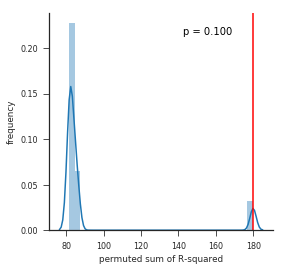

In [29]:
with plt.style.context(('seaborn-ticks', 'seaborn-paper')):
    fig, ax = plt.subplots()

sns.distplot(perm_results, ax=ax)
plt.axvline(x=perm_results[0], color='red')
ax.set_ylabel('frequency')
ax.set_xlabel('permuted sum of R-squared')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.annotate("p = {:.3f}".format(1-(perm_results < perm_results[0]).sum()/perm_results.shape[0]), xy=(.6, .9), xycoords=ax.transAxes)

sns.despine(fig)

save_plot(fig, 'pairingmatters_hist')

In [30]:
kos = df_direct_shotgun.sum(axis=1).sort_values(ascending=False).head(25)

In [31]:
df_shotgun = df_direct_shotgun.T
df_16s = df_picrust_16s.T
set_shotgun = set(df_shotgun.columns)
set_df_16s = set(df_16s.columns)

# for col in set_shotgun.difference(set_df_16s):
#     df_16s_clean[col] = 0

for col in set_df_16s.difference(set_shotgun):
    df_shotgun[col] = 0

for col in set_shotgun.difference(set_df_16s):
    df_16s[col] = 0

In [32]:
palette = sns.xkcd_palette(['royal blue', 'light red', 'ochre', 'black', 'grey', 'sky blue', 'dark turquoise', 'emerald', 'light purple', 'gold', 'night blue', 'green', 'maroon', 'orchid', 'deep pink', 'light grey blue', 'old rose', 'light pink', 'pale aqua', 'yellow', 'lime green', 'dark orange', 'brown'])
color_map = ListedColormap(palette)

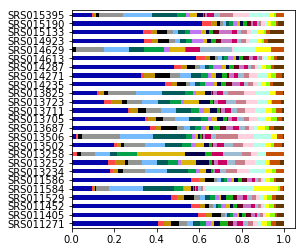

In [33]:
fig, ax = plt.subplots()

df = df_shotgun.head(25)[kos.index]
df += 1
df = (df.T/df.T.sum()).T
df.plot.barh(stacked=True, legend=False, colormap=color_map, ax=ax)

save_plot(fig, 'shotgun_stacked_bar')

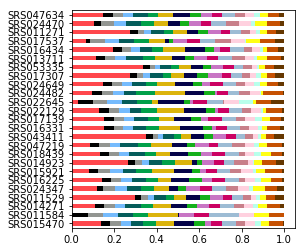

In [34]:
fig, ax = plt.subplots()

df = df_16s.head(25)[kos.index]
df += 1
df = (df.T/df.T.sum()).T
df.plot.barh(stacked=True, legend=False, colormap=color_map, ax=ax, figsize=(12,12))
#fig1 = custom_legend(fig, color_map, df.columns)
#save_plot(fig, '16s_prevotella', artists=(fig1,))
save_plot(fig, '16s_stackedbar')

In [35]:
list_16s_dfs = []
list_shotgun_dfs = []
dict_missing_shotgun = defaultdict(list)
dict_missing_16s = defaultdict(list)
for (group_16, df_16), (group_shotgun, df_shotgun) in zip(df_16s_clean.groupby('bodysite'), df_shotgun_clean.groupby('bodysite')):
    # Run the prevalence filter
    df_16 = df_16.drop("bodysite", axis=1)
    df_16 = df_16.loc[:, (df_16 > 0).sum(axis=0)/df_16.shape[0] > .1]

    # Run the prevlance filter
    df_shotgun = df_shotgun.drop("bodysite", axis=1)
    df_shotgun = df_shotgun.loc[:, (df_shotgun > 0).sum(axis=0)/df_shotgun.shape[0] > .1]
    
    # Reindex both dataframes according to missing columns
    set_shotgun = set(df_shotgun.columns)
    set_df_16s = set(df_16.columns)

    for col in set_df_16s.difference(set_shotgun):
        df_shotgun[col] = 0
        for index in df_shotgun.index:
            dict_missing_shotgun[index].append(col)
    
    for col in set_shotgun.difference(set_df_16s):
        df_16[col] = 0
        for index in df_16.index:
            dict_missing_16s[index].append(col)

    #df_shotgun = df_shotgun[list(set_df_16s)]
    #df_16s = df_16s[list(set_shotgun)]
    
    df_16 += .001
    #mat_16 = multiplicative_replacement2(df_16, delta=.2)
    #df_16 = pd.DataFrame(clr(mat_16), index=df_16.index, columns=df_16.columns)
    df_16 = (df_16.T/df_16.T.sum()).T
    list_16s_dfs.append(df_16.copy())
    df_shotgun += .001
    #mat_shotgun = multiplicative_replacement2(df_shotgun, delta=.2)
    df_shotgun = (df_shotgun.T/df_shotgun.T.sum()).T
    #df_shotgun = pd.DataFrame(clr(mat_shotgun), index=df_shotgun.index, columns=df_shotgun.columns)
    list_shotgun_dfs.append(df_shotgun.copy())

df_clr_shotgun = pd.concat(list_shotgun_dfs)
df_clr_shotgun = df_clr_shotgun.dropna(axis=1, how="all")
df_clr_16s = pd.concat(list_16s_dfs)
df_clr_16s = df_clr_16s.dropna(axis=1, how="all")
df_clr_shotgun= df_clr_shotgun.reindex(sorted(df_clr_shotgun.columns), axis=1)
df_clr_16s= df_clr_16s.reindex(sorted(df_clr_16s.columns), axis=1)

In [36]:
df_colors = pd.DataFrame(np.zeros(df_clr_shotgun.shape), index=df_clr_shotgun.index, columns=df_clr_shotgun.columns)

for k, vs in dict_missing_shotgun.items():
    for v in vs:
        df_colors.loc[k, v] = 1
    
for k, vs in dict_missing_16s.items():
    for v in vs:
        df_colors.loc[k, v] = 2    

In [37]:
# Join up mapping ids
dfgroup_clr_shotgun = df_clr_shotgun.join(series_hmp_bodysite, how="inner").groupby('bodysite').mean()
dfgroup_clr_16s = df_clr_16s.join(series_hmp_bodysite, how="inner").groupby('bodysite').mean()

In [38]:
def yield_summaries(df, df_colors):
    #['shotgun_both','shotgun_shotgun','shotgun_16s_bacteria','shotgun_16s','16s_both','16s_shotgun','16s_16s_bacteria','16s_16s']
    for i in df_clr_shotgun.index:
        if i in df_clr_shotgun.index and i in df_clr_16s.index:
            yield [df.loc[i, :][df_colors.loc[i, :] == 0].dropna().sum(),
             df.loc[i, :][df_colors.loc[i, :] == 1].dropna().sum(),
             df.loc[i, :][df_colors.loc[i, :] == 2].dropna().sum(),
             df.loc[i, :][df_colors.loc[i, :] == 3].dropna().sum()]

In [39]:
df_prop_shotgun = pd.DataFrame(yield_summaries(df_clr_shotgun, df_colors), columns=['both','16s only','shotgun bacteria only','shotgun non-bacteria only'], index=df_clr_shotgun.index)
df_prop_16s = pd.DataFrame(yield_summaries(df_clr_16s, df_colors), columns=['both','16s only','shotgun bacteria only','shotgun non-bacteria only'], index=df_clr_shotgun.index)

In [40]:
df_grouped_shotgun = df_prop_shotgun.join(series_hmp_bodysite, how="inner").groupby('bodysite').mean()
df_grouped_16s = df_prop_16s.join(series_hmp_bodysite, how="inner").groupby('bodysite').mean()

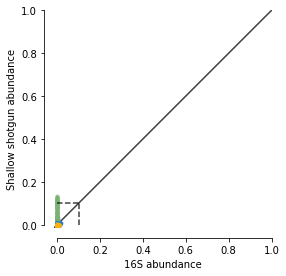

In [41]:
fig, ax = plt.subplots()

palette = sns.xkcd_palette(["windows blue", "amber", "faded green", "dusty purple"])

for i in df_clr_shotgun.index:
    if i in df_clr_shotgun.index and i in df_clr_16s.index:
        ax.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 0].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 0].dropna(), color=palette[0], marker="o", alpha=.5, zorder=1, edgecolor='face', s=10)
        ax.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 1].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 1].dropna(), color=palette[1], marker="o", alpha=.5, zorder=3, edgecolor='face', s=10)
        ax.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 2].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 2].dropna(), color=palette[2], marker="o", alpha=.5, zorder=1, edgecolor='face', s=10)
        ax.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 3].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 3].dropna(), color=palette[3], marker="o", alpha=.5, zorder=2, edgecolor='face', s=10)

ax.xaxis.set_ticks(np.arange(0, 1.1, .2))
ax.yaxis.set_ticks(np.arange(0, 1.1, .2))
ax.axis=['equal']
        
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)


# draw vertical line from (70,100) to (70, 250)
ax.plot([0, .1], [.1, .1], 'k--', alpha=.75, zorder=4)

# draw diagonal line from (70, 90) to (90, 200)
ax.plot([.1, .1], [0, .1], 'k--', alpha=.75, zorder=4)


#leg1 = custom_legend(ax, palette, ["Both", "16S only", "Shallow shotgun only"])
ax.set_ylabel("Shallow shotgun abundance")
ax.set_xlabel("16S abundance")

sns.despine(offset=10, trim=True)

save_plot(fig, "scatterplot_abundance")

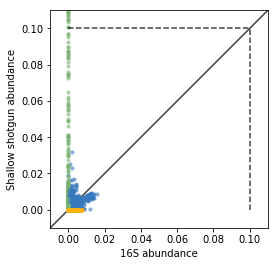

In [42]:
fig, ax = plt.subplots()

palette = sns.xkcd_palette(["windows blue", "amber", "faded green", "dusty purple"])

for i in df_clr_shotgun.index:
    if i in df_clr_shotgun.index and i in df_clr_16s.index:
        ax.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 0].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 0].dropna(), color=palette[0], marker="o", alpha=.5, zorder=1, edgecolor='face', s=10)
        ax.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 1].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 1].dropna(), color=palette[1], marker="o", alpha=.5, zorder=3, edgecolor='face', s=10)
        ax.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 2].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 2].dropna(), color=palette[2], marker="o", alpha=.5, zorder=1, edgecolor='face', s=10)
        ax.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 3].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 3].dropna(), color=palette[3], marker="o", alpha=.5, zorder=2, edgecolor='face', s=10)

ax.xaxis.set_ticks(np.arange(0, .11, .02))
ax.yaxis.set_ticks(np.arange(0, .11, .02))
ax.set_ylim(-0.01, .11)
ax.set_xlim(-0.01, .11)
ax.axis=['equal']
        
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# draw vertical line from (70,100) to (70, 250)
ax.plot([0, .1], [.1, .1], 'k--', alpha=.75, zorder=4)

# draw diagonal line from (70, 90) to (90, 200)
ax.plot([.1, .1], [0, .1], 'k--', alpha=.75, zorder=4)

#leg1 = custom_legend(ax, palette, ["Both", "16S only", "Shotgun only", "Shotgun non-bacteria"])
ax.set_ylabel("Shallow shotgun abundance")
ax.set_xlabel("16S abundance")

save_plot(fig, "inset_scatterplot_abundance")

/home/bhillmann/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


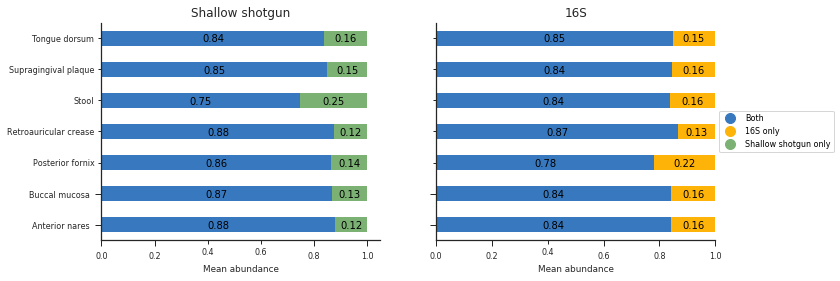

In [43]:
with plt.style.context(('seaborn-ticks', 'seaborn-paper')):
    fig = plt.figure(figsize=(5.5,2))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
color_map = ListedColormap(palette)

df_grouped_shotgun.index = [_.replace("_", " ") for _ in df_grouped_shotgun.index]

ax1 = df_grouped_shotgun.plot.barh(stacked=True, legend=False, ax=ax1, colormap=color_map)
ax1.set_xlabel("Mean abundance")
ax1.set_title("Shallow shotgun")
#ax1.yaxis.tick_right()

stylize_axes(ax1)

df_grouped_16s.plot.barh(stacked=True, legend=False, colormap=color_map, ax=ax2)
stylize_axes(ax2)
ax2.set_ylabel("")
ax2.set_xlabel("Mean abundance")
ax2.set_title("16S")
ax2.set_yticklabels("")

for p in ax1.patches:
    if p.get_width() >= .08:
        ax1.annotate("%.2f" % p.get_width(), (p.get_x()+p.get_width()/2, p.get_y()), xytext=(0, 4), fontsize=10, textcoords='offset points', horizontalalignment='center')
        
for p in ax2.patches:
    if p.get_width() >= .08:
        ax2.annotate("%.2f" % p.get_width(), (p.get_x()+p.get_width()/2, p.get_y()), xytext=(0, 4), fontsize=10, textcoords='offset points', horizontalalignment='center')
    

leg1 = custom_legend(ax2, palette, ["Both", "16S only", "Shallow shotgun only"])

save_plot(fig, "stacked_hbar_both_abundance", size_inches=(11,4), artists=(leg1,))

/home/bhillmann/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


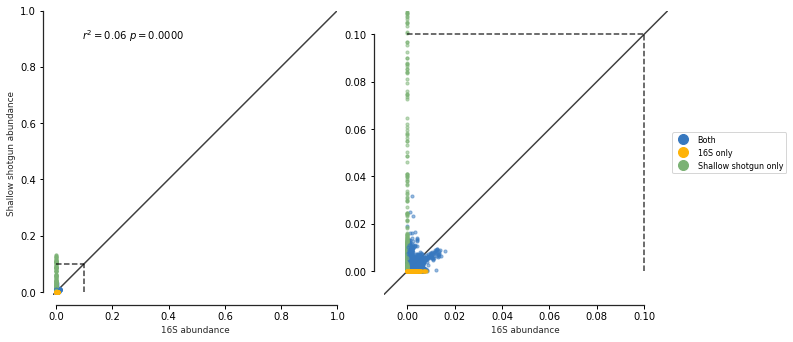

In [44]:
with plt.style.context(('seaborn-ticks', 'seaborn-paper')):
    fig = plt.figure(figsize=(11, 8))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

palette = sns.xkcd_palette(["windows blue", "amber", "faded green", "dusty purple"])

for i in df_clr_shotgun.index:
    if i in df_clr_shotgun.index and i in df_clr_16s.index:
        ax2.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 0].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 0].dropna(), color=palette[0], marker="o", alpha=.5, zorder=1, edgecolor='face', s=10)
        ax2.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 1].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 1].dropna(), color=palette[1], marker="o", alpha=.5, zorder=3, edgecolor='face', s=10)
        ax2.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 2].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 2].dropna(), color=palette[2], marker="o", alpha=.5, zorder=1, edgecolor='face', s=10)
        ax2.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 3].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 3].dropna(), color=palette[3], marker="o", alpha=.5, zorder=2, edgecolor='face', s=10)

ax2.xaxis.set_ticks(np.arange(0, .11, .02))
ax2.yaxis.set_ticks(np.arange(0, .11, .02))
ax2.set_ylim(-0.01, .11)
ax2.set_xlim(-0.01, .11)
ax2.axis=['equal']
        
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax2.set_aspect('equal')
ax2.set_xlim(lims)
ax2.set_ylim(lims)

# draw vertical line from (70,100) to (70, 250)
ax2.plot([0, .1], [.1, .1], 'k--', alpha=.75, zorder=4)

# draw diagonal line from (70, 90) to (90, 200)
ax2.plot([.1, .1], [0, .1], 'k--', alpha=.75, zorder=4)

#leg1 = custom_legend(ax, palette, ["Both", "16S only", "Shotgun only", "Shotgun non-bacteria"])
ax1.set_ylabel("Shallow shotgun abundance")
ax1.set_xlabel("16S abundance")

for i in df_clr_shotgun.index:
    if i in df_clr_shotgun.index and i in df_clr_16s.index:
        ax1.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 0].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 0].dropna(), color=palette[0], marker="o", alpha=.5, zorder=1, edgecolor='face', s=10)
        ax1.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 1].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 1].dropna(), color=palette[1], marker="o", alpha=.5, zorder=3, edgecolor='face', s=10)
        ax1.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 2].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 2].dropna(), color=palette[2], marker="o", alpha=.5, zorder=1, edgecolor='face', s=10)
        ax1.scatter(df_clr_16s.loc[i, :][df_colors.loc[i, :] == 3].dropna(), df_clr_shotgun.loc[i, :][df_colors.loc[i, :] == 3].dropna(), color=palette[3], marker="o", alpha=.5, zorder=2, edgecolor='face', s=10)

ax1.xaxis.set_ticks(np.arange(0, 1.01, .2))
ax1.yaxis.set_ticks(np.arange(0, 1.01, .2))
ax1.axis=['equal']
        
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set_aspect('equal')
ax1.set_xlim(lims)
ax1.set_ylim(lims)

# draw vertical line from (70,100) to (70, 250)
ax1.plot([0, .1], [.1, .1], 'k--', alpha=.75, zorder=4)

# draw diagonal line from (70, 90) to (90, 200)
ax1.plot([.1, .1], [0, .1], 'k--', alpha=.75, zorder=4)

from scipy.stats import pearsonr

x = df_clr_16s.loc[df_clr_shotgun.index, :].values.flatten()
x = x[~np.isnan(x)]

y = df_clr_shotgun.values.flatten()
y = y[~np.isnan(y)]

r, p = pearsonr(x, y)
r = r*r

ax1.annotate(r"$r^2 = {:.2f}$ $p = {:.4f}$".format(r,p), xy=(.1, .9), xycoords=ax1.transAxes)
#ax1.annotate(r"$p = {:.4f}$".format(p), xy=(.4, .9), xycoords=ax1.transAxes)
stylize_axes(ax1)
stylize_axes(ax2)

leg1 = custom_legend(ax2, palette, ["Both", "16S only", "Shallow shotgun only"])
#ax2.set_ylabel("Shallow shotgun abundance")
ax2.set_xlabel("16S abundance")
plt.tight_layout()

sns.despine(offset=10, trim=True)

#fig.text(.5, -0.1, "16S Abundance", ha='center', va='center')
save_plot(fig, "scatterplot_both_abundance", size_inches=(11,8), artists=(leg1,))

In [45]:
from scipy.stats import pearsonr

x = df_clr_16s.loc[df_clr_shotgun.index, :].values.flatten()
x = x[~np.isnan(x)]

y = df_clr_shotgun.values.flatten()
y = y[~np.isnan(y)]

r, p = pearsonr(x, y)
r = r*r

In [46]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(x, y)

In [47]:
slope, intercept, r_value, p_value

(0.5934918745556319, 7.5372101837324648e-05, 0.24336662076498164, 0.0)